In [1]:
with open('../data/Korean_movie_reviews_2016_small.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f ]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [2]:
len(texts)

29875

In [3]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

In [5]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, y_one_hot, test_size=0.2, random_state=0)

In [7]:
len(X_train)

23900

In [8]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

In [9]:
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels = 2
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
optimizer = tf.keras.optimizers.Adam(2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_kr_multi"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True,
                     save_weights_only=True,
    )

In [12]:
history = model.fit(dict(X_train_tokenized), y_train, epochs=10, batch_size=128, validation_split=0.1,
                   callbacks=[es, mc])

Epoch 1/10
169/169 [==============================] - 1093s 6s/step - loss: 0.5084 - accuracy: 0.7382 - val_loss: 0.4217 - val_accuracy: 0.8113
Epoch 2/10
169/169 [==============================] - 1075s 6s/step - loss: 0.3654 - accuracy: 0.8377 - val_loss: 0.3764 - val_accuracy: 0.8406
Epoch 3/10
169/169 [==============================] - 1082s 6s/step - loss: 0.2961 - accuracy: 0.8730 - val_loss: 0.3540 - val_accuracy: 0.8381
Epoch 4/10
169/169 [==============================] - 1065s 6s/step - loss: 0.2497 - accuracy: 0.8982 - val_loss: 0.3972 - val_accuracy: 0.8444
Epoch 5/10
169/169 [==============================] - 1710s 10s/step - loss: 0.2041 - accuracy: 0.9191 - val_loss: 0.4127 - val_accuracy: 0.8444
Epoch 6/10
169/169 [==============================] - 1918s 11s/step - loss: 0.1674 - accuracy: 0.9363 - val_loss: 0.4803 - val_accuracy: 0.8347
Epoch 6: early stopping


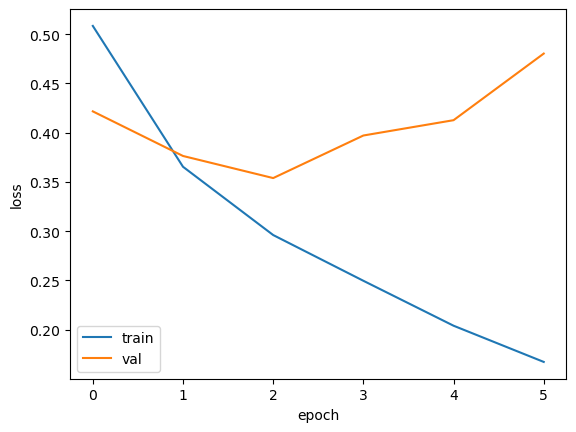

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

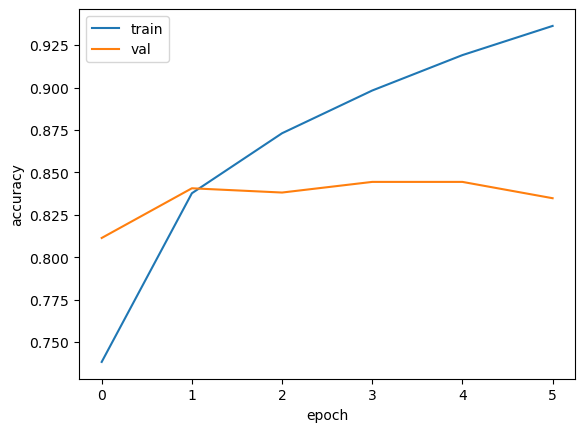

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [15]:
model.load_weights(checkpoint_filepath)
model.evaluate(dict(X_test_tokenized), y_test)

187/187 [==============================] - 237s 1s/step - loss: 0.3327 - accuracy: 0.8552


[0.33266681432724, 0.8552301526069641]

In [16]:
y_preds = model.predict(dict(X_test_tokenized))

187/187 [==============================] - 253s 1s/step


In [17]:
prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()

In [19]:
import numpy as np

In [20]:
y_predictions = np.argmax(prediction_probs, axis=1)

In [21]:
y_test = np.argmax(y_test, axis=1)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_predictions, y_test))

              precision    recall  f1-score   support

           0       0.89      0.82      0.86      3114
           1       0.82      0.89      0.86      2861

    accuracy                           0.86      5975
   macro avg       0.86      0.86      0.86      5975
weighted avg       0.86      0.86      0.86      5975

